检查.mat文件结构...
Mat文件内容:
  - M: 形状=(300, 300), 类型=float32, 值范围=[0.0, 14.0]
    唯一值: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
使用设备: cuda
训练集大小: 160, 验证集大小: 41
样本图像形状: torch.Size([3, 128, 128])
样本掩码形状: torch.Size([128, 128])
掩码唯一值: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
检测到类别数量: 15
创建了具有15个输出类别的模型
开始训练 ReLU 模型，共 15 轮...


C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_9816\3829393466.py:84: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = mask.resize((128, 128), Image.NEAREST)


Epoch 1/15, Train Loss: 2.4583, Train Acc: 0.4924, Val Loss: 2.4654, Val Acc: 0.8964
Epoch 2/15, Train Loss: 2.1911, Train Acc: 0.7617, Val Loss: 2.2900, Val Acc: 0.8941
Epoch 3/15, Train Loss: 1.9950, Train Acc: 0.8318, Val Loss: 2.0504, Val Acc: 0.8817
Epoch 4/15, Train Loss: 1.8292, Train Acc: 0.8708, Val Loss: 1.8039, Val Acc: 0.8922
Epoch 5/15, Train Loss: 1.6816, Train Acc: 0.8865, Val Loss: 1.6000, Val Acc: 0.8977
Epoch 6/15, Train Loss: 1.5451, Train Acc: 0.8942, Val Loss: 1.4495, Val Acc: 0.8957
Epoch 7/15, Train Loss: 1.4174, Train Acc: 0.8977, Val Loss: 1.2935, Val Acc: 0.9022
Epoch 8/15, Train Loss: 1.2980, Train Acc: 0.9004, Val Loss: 1.1732, Val Acc: 0.9058
Epoch 9/15, Train Loss: 1.1859, Train Acc: 0.9126, Val Loss: 1.0647, Val Acc: 0.9183
Epoch 10/15, Train Loss: 1.0818, Train Acc: 0.9158, Val Loss: 0.9708, Val Acc: 0.9194
Epoch 11/15, Train Loss: 0.9873, Train Acc: 0.9174, Val Loss: 0.8900, Val Acc: 0.9197
Epoch 12/15, Train Loss: 0.9018, Train Acc: 0.9186, Val Loss: 0

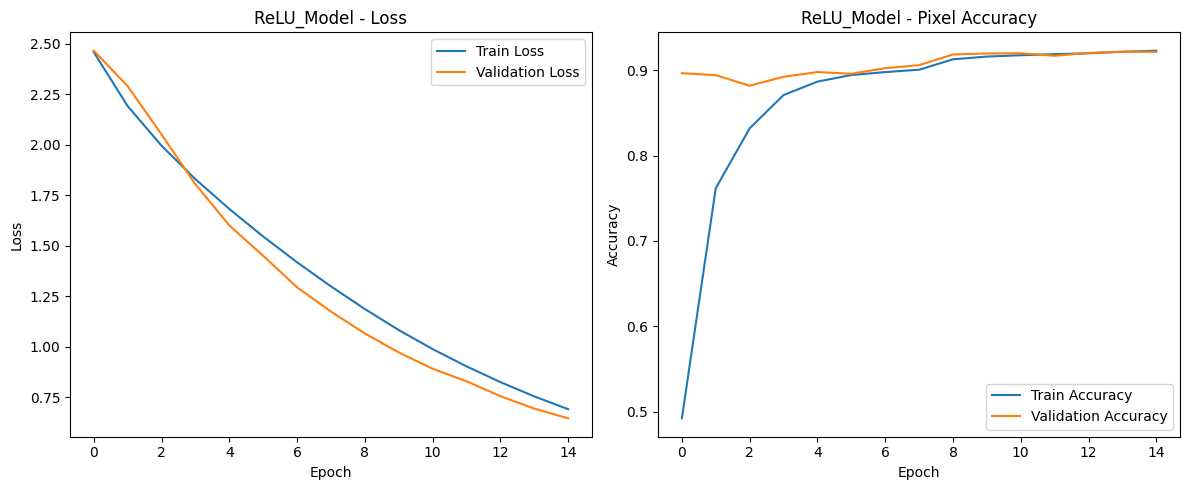

生成预测可视化...


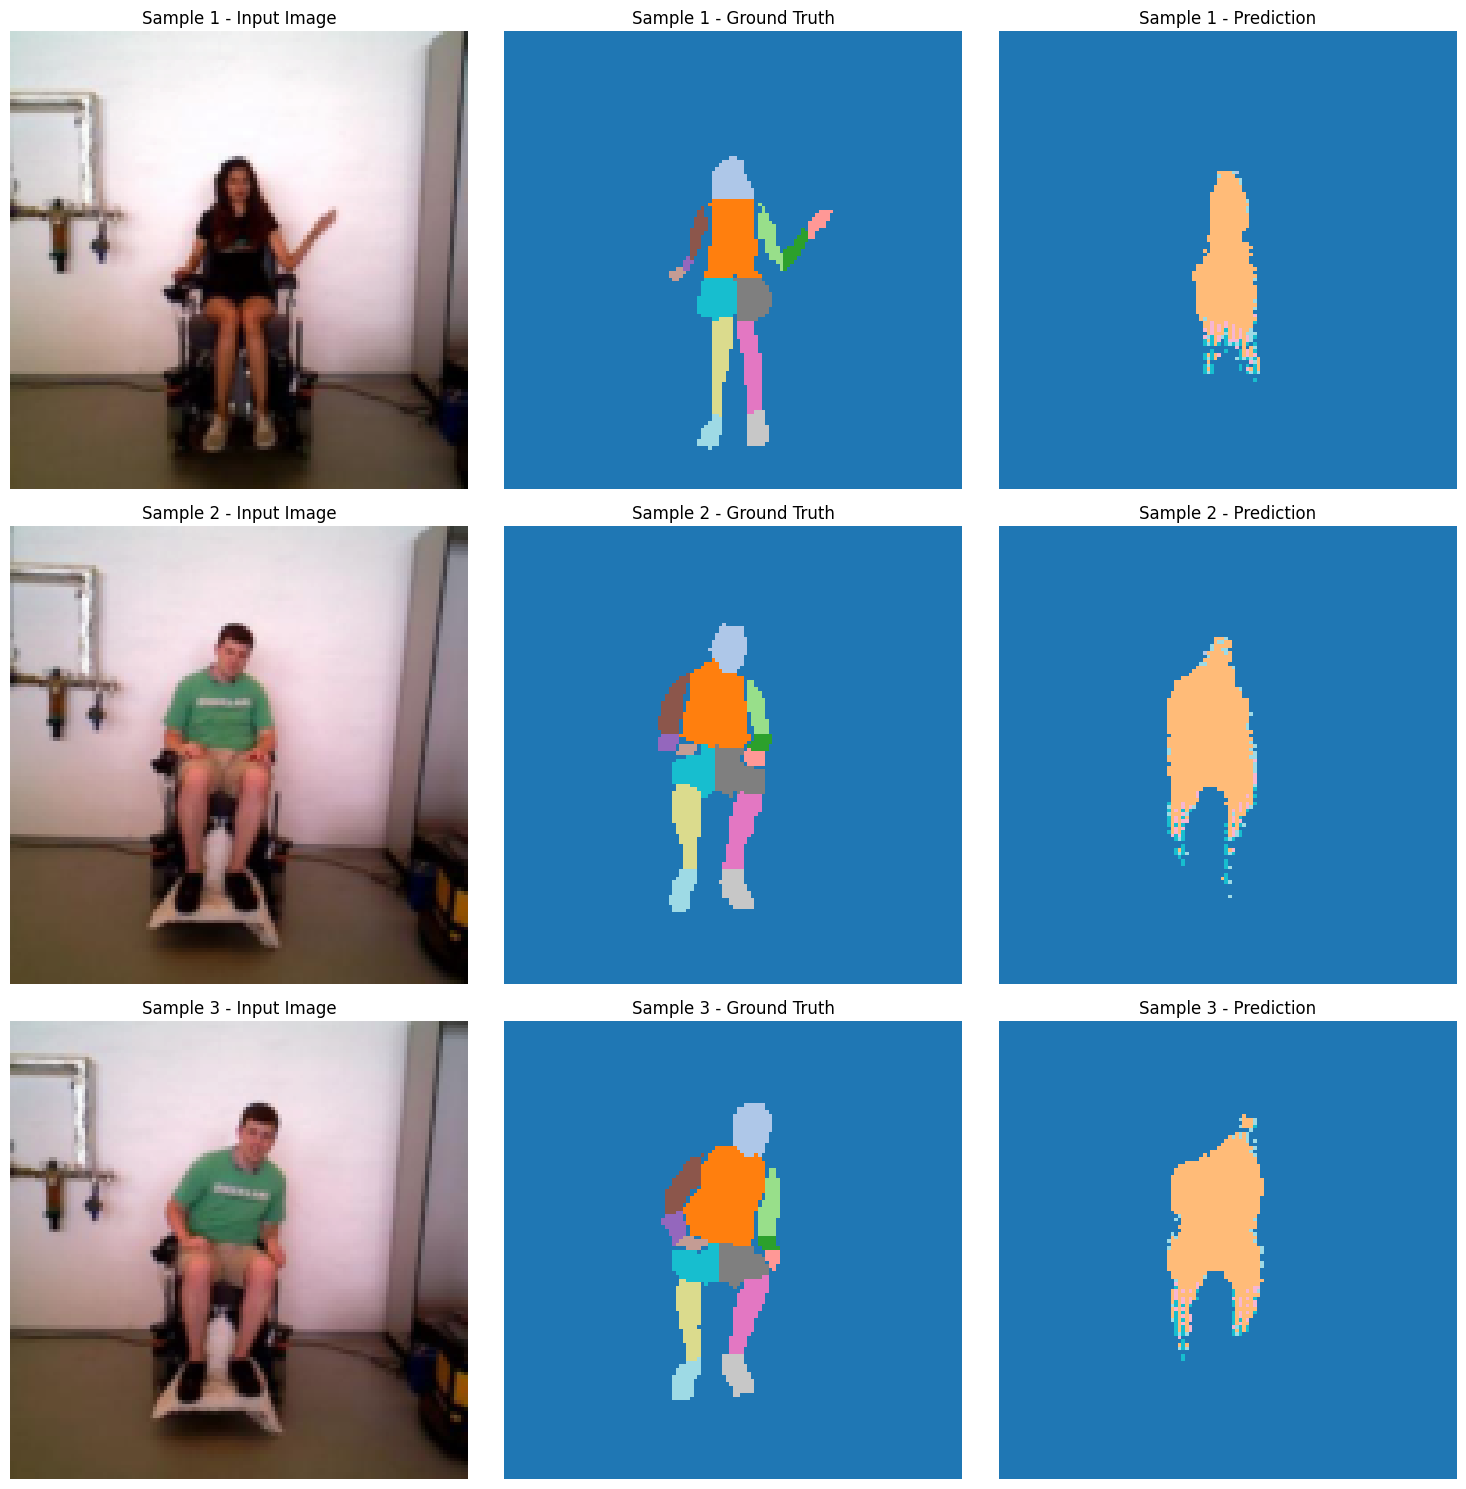

模型已保存为 'relu_model.pth'

最终结果:
训练准确率: 0.9227
验证准确率: 0.9213
训练时间: 22.44 秒


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import scipy.io as sio  # 用于读取.mat文件

class FreiburgSittingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, train=True, train_ratio=0.8):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # 获取所有图像文件名
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        # 分割训练集和测试集
        np.random.seed(42)  # 设置随机种子确保可重复性
        indices = np.arange(len(self.img_files))
        np.random.shuffle(indices)
        
        split_idx = int(len(indices) * train_ratio)
        if train:
            self.indices = indices[:split_idx]
        else:
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # 获取真实索引
        true_idx = self.indices[idx]
        img_name = self.img_files[true_idx]
        
        # 加载图像
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # 构建对应的mat文件名
        # 假设mat文件与图像文件同名，只是扩展名不同
        mat_name = os.path.splitext(img_name)[0] + '.mat'
        mat_path = os.path.join(self.mask_dir, mat_name)
        
        # 加载mat文件
        try:
            mat_data = sio.loadmat(mat_path)
            
            # 提取掩码数据
            # 注意：这里需要根据实际mat文件结构调整
            # 假设mat文件中有一个名为'mask'或'segmentation'的变量
            # 您可能需要根据实际mat文件结构修改这部分
            if 'mask' in mat_data:
                mask = mat_data['mask']
            elif 'segmentation' in mat_data:
                mask = mat_data['segmentation']
            else:
                # 尝试获取第一个非特殊变量（通常.mat文件会包含一些元数据变量）
                for key in mat_data.keys():
                    if not key.startswith('__'):  # 跳过特殊变量如__header__
                        mask = mat_data[key]
                        break
            
            # 确保掩码是正确的形状和类型
            mask = np.array(mask, dtype=np.int64)
            
        except Exception as e:
            print(f"无法加载mat文件 {mat_path}: {e}")
            # 在出错的情况下提供默认掩码（全零）
            mask = np.zeros((image.height, image.width), dtype=np.int64)
        
        # 应用变换
        if self.transform:
            image = self.transform(image)
            
            # 调整掩码大小与图像一致（假设为128x128）
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize((128, 128), Image.NEAREST)
            mask = np.array(mask)
            
        # 将掩码转换为torch张量
        mask_tensor = torch.from_numpy(mask).long()
            
        return image, mask_tensor

class LightweightSegNet(nn.Module):
    def __init__(self, num_classes=14):  # 根据您提到的数据集有14个分割部分
        super(LightweightSegNet, self).__init__()
        
        # 编码器部分 - 非常轻量级
        self.encoder = nn.Sequential(
            # 第一层
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64
            
            # 第二层
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32
            
            # 第三层 - 最后一层编码
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
        )
        
        # 解码器部分 - 轻量级解码
        self.decoder = nn.Sequential(
            # 第一层解码
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 第二层解码
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            # 第三层解码
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            # 最终输出层
            nn.Conv2d(16, num_classes, kernel_size=1)  # 1x1卷积调整到指定类别数
        )
        
    def forward(self, x):
        # 编码
        x = self.encoder(x)
        # 解码
        x = self.decoder(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """训练模型并评估性能"""
    model.to(device)
    
    # 记录训练过程
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    
    # 开始计时
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            # 统计
            running_loss += loss.item()
            
            # 计算像素级准确率
            _, predicted = torch.max(outputs, 1)
            correct_pixels += (predicted == masks).sum().item()
            total_pixels += masks.numel()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_pixels / total_pixels
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)
        
        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_correct_pixels = 0
        val_total_pixels = 0
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                
                # 前向传播
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                
                # 统计
                val_running_loss += loss.item()
                
                # 计算像素级准确率
                _, predicted = torch.max(outputs, 1)
                val_correct_pixels += (predicted == masks).sum().item()
                val_total_pixels += masks.numel()
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_correct_pixels / val_total_pixels
        val_losses.append(val_epoch_loss)
        val_accuracy.append(val_epoch_acc)
        
        # 打印每个epoch的结果
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
    
    # 计算总训练时间
    total_time = time.time() - start_time
    print(f'训练完成，总用时: {total_time:.2f} 秒')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': total_time
    }

def visualize_results(results, model_name):
    """可视化训练结果"""
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(results['train_accuracy'], label='Train Accuracy')
    plt.plot(results['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    """可视化模型的预测结果"""
    model.eval()
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # 转回CPU进行可视化
            input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
            # 反标准化图像
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            input_img = std * input_img + mean
            input_img = np.clip(input_img, 0, 1)
            
            true_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            
            # 绘制原图、真实标签和预测标签
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(input_img)
            plt.title(f'Sample {i+1} - Input Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Ground Truth')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')
            
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

def inspect_mat_file(mat_path):
    """检查.mat文件的内容和结构"""
    try:
        mat_data = sio.loadmat(mat_path)
        print(f"Mat文件内容:")
        for key in mat_data.keys():
            if not key.startswith('__'):  # 跳过特殊变量
                value = mat_data[key]
                print(f"  - {key}: 形状={value.shape}, 类型={value.dtype}, 值范围=[{np.min(value)}, {np.max(value)}]")
                # 打印唯一值，查看是否是分类标签
                unique_values = np.unique(value)
                if len(unique_values) < 20:  # 如果唯一值数量较少，可能是类别标签
                    print(f"    唯一值: {unique_values}")
        return mat_data
    except Exception as e:
        print(f"无法读取mat文件: {e}")
        return None

def main():
    # 设置路径
    img_dir = "D:/人体姿态检测2025/img"
    mask_dir = "D:/人体姿态检测2025/masks"
    
    # 检查目录是否存在
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"请确保图像目录 {img_dir} 和掩码目录 {mask_dir} 都存在")
    
    # 首先检查一个.mat文件，了解其结构
    print("检查.mat文件结构...")
    # 查找第一个.mat文件
    mat_files = [f for f in os.listdir(mask_dir) if f.endswith('.mat')]
    if mat_files:
        sample_mat = os.path.join(mask_dir, mat_files[0])
        mat_data = inspect_mat_file(sample_mat)
    else:
        print("未找到.mat文件，请确认masks目录中包含.mat文件")
        return
    
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 数据变换
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 创建数据集
    train_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=True)
    val_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=False)
    
    # 检查数据集大小
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")
    
    # 检查第一个样本
    sample_image, sample_mask = train_dataset[0]
    print(f"样本图像形状: {sample_image.shape}")
    print(f"样本掩码形状: {sample_mask.shape}")
    print(f"掩码唯一值: {torch.unique(sample_mask)}")
    
    # 确定类别数量 (14个部分 + 背景类)
    num_classes = len(torch.unique(sample_mask)) if len(torch.unique(sample_mask)) > 0 else 15
    print(f"检测到类别数量: {num_classes}")
    
    # 创建数据加载器
    batch_size = 16  # 小批量以减少内存使用
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # 创建模型
    model = LightweightSegNet(num_classes=num_classes)
    print(f"创建了具有{num_classes}个输出类别的模型")
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练模型
    num_epochs = 15  # 减少训练轮次以加快训练
    print(f"开始训练 ReLU 模型，共 {num_epochs} 轮...")
    
    results = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=num_epochs, 
        device=device
    )
    
    # 可视化训练结果
    visualize_results(results, "ReLU_Model")
    
    # 可视化一些预测结果
    print("生成预测可视化...")
    visualize_predictions(model, val_loader, device)
    
    # 保存模型
    torch.save(model.state_dict(), 'relu_model.pth')
    print("模型已保存为 'relu_model.pth'")
    
    # 输出最终结果
    print(f"\n最终结果:")
    print(f"训练准确率: {results['train_accuracy'][-1]:.4f}")
    print(f"验证准确率: {results['val_accuracy'][-1]:.4f}")
    print(f"训练时间: {results['training_time']:.2f} 秒")

if __name__ == "__main__":
    main()

检查.mat文件结构...
Mat文件内容:
  - M: 形状=(300, 300), 类型=float32, 值范围=[0.0, 14.0]
    唯一值: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
使用设备: cuda
训练集大小: 160, 验证集大小: 41
样本图像形状: torch.Size([3, 128, 128])
样本掩码形状: torch.Size([128, 128])
掩码唯一值: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
检测到类别数量: 15
创建了具有15个输出类别的模型
开始训练 GELU 模型，共 15 轮...


C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_9816\1481805138.py:84: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = mask.resize((128, 128), Image.NEAREST)


Epoch 1/15, Train Loss: 2.5219, Train Acc: 0.5723, Val Loss: 2.5021, Val Acc: 0.8983
Epoch 2/15, Train Loss: 2.3453, Train Acc: 0.7725, Val Loss: 2.3329, Val Acc: 0.8853
Epoch 3/15, Train Loss: 2.2246, Train Acc: 0.7870, Val Loss: 2.1682, Val Acc: 0.8173
Epoch 4/15, Train Loss: 2.1157, Train Acc: 0.7707, Val Loss: 2.0413, Val Acc: 0.7817
Epoch 5/15, Train Loss: 2.0028, Train Acc: 0.7709, Val Loss: 1.8884, Val Acc: 0.7911
Epoch 6/15, Train Loss: 1.8878, Train Acc: 0.7797, Val Loss: 1.7371, Val Acc: 0.8014
Epoch 7/15, Train Loss: 1.7717, Train Acc: 0.7912, Val Loss: 1.6363, Val Acc: 0.8175
Epoch 8/15, Train Loss: 1.6548, Train Acc: 0.8199, Val Loss: 1.5121, Val Acc: 0.8651
Epoch 9/15, Train Loss: 1.5392, Train Acc: 0.8548, Val Loss: 1.4176, Val Acc: 0.8919
Epoch 10/15, Train Loss: 1.4240, Train Acc: 0.8808, Val Loss: 1.3679, Val Acc: 0.8981
Epoch 11/15, Train Loss: 1.3087, Train Acc: 0.8993, Val Loss: 1.2565, Val Acc: 0.9144
Epoch 12/15, Train Loss: 1.1949, Train Acc: 0.9135, Val Loss: 1

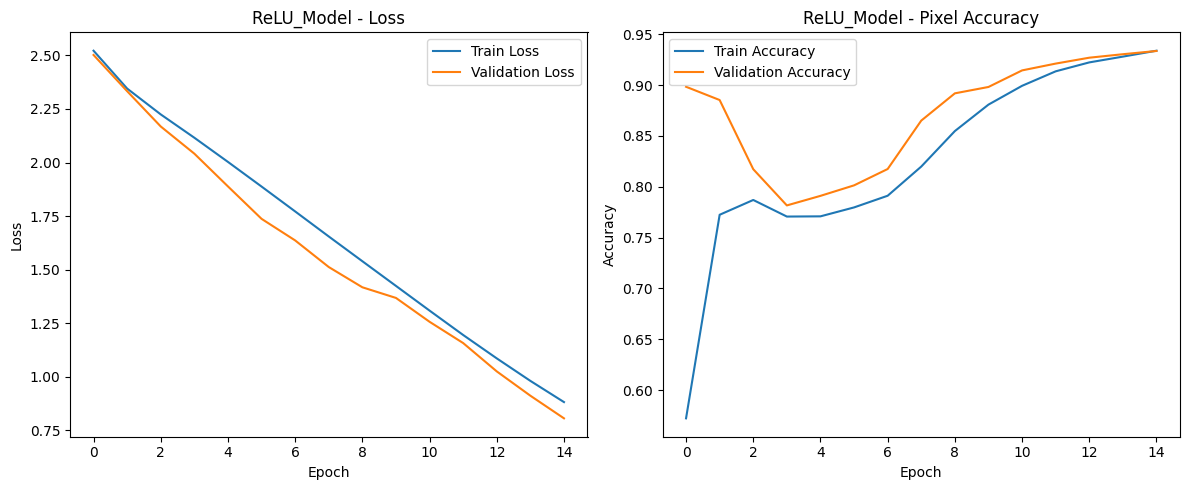

生成预测可视化...


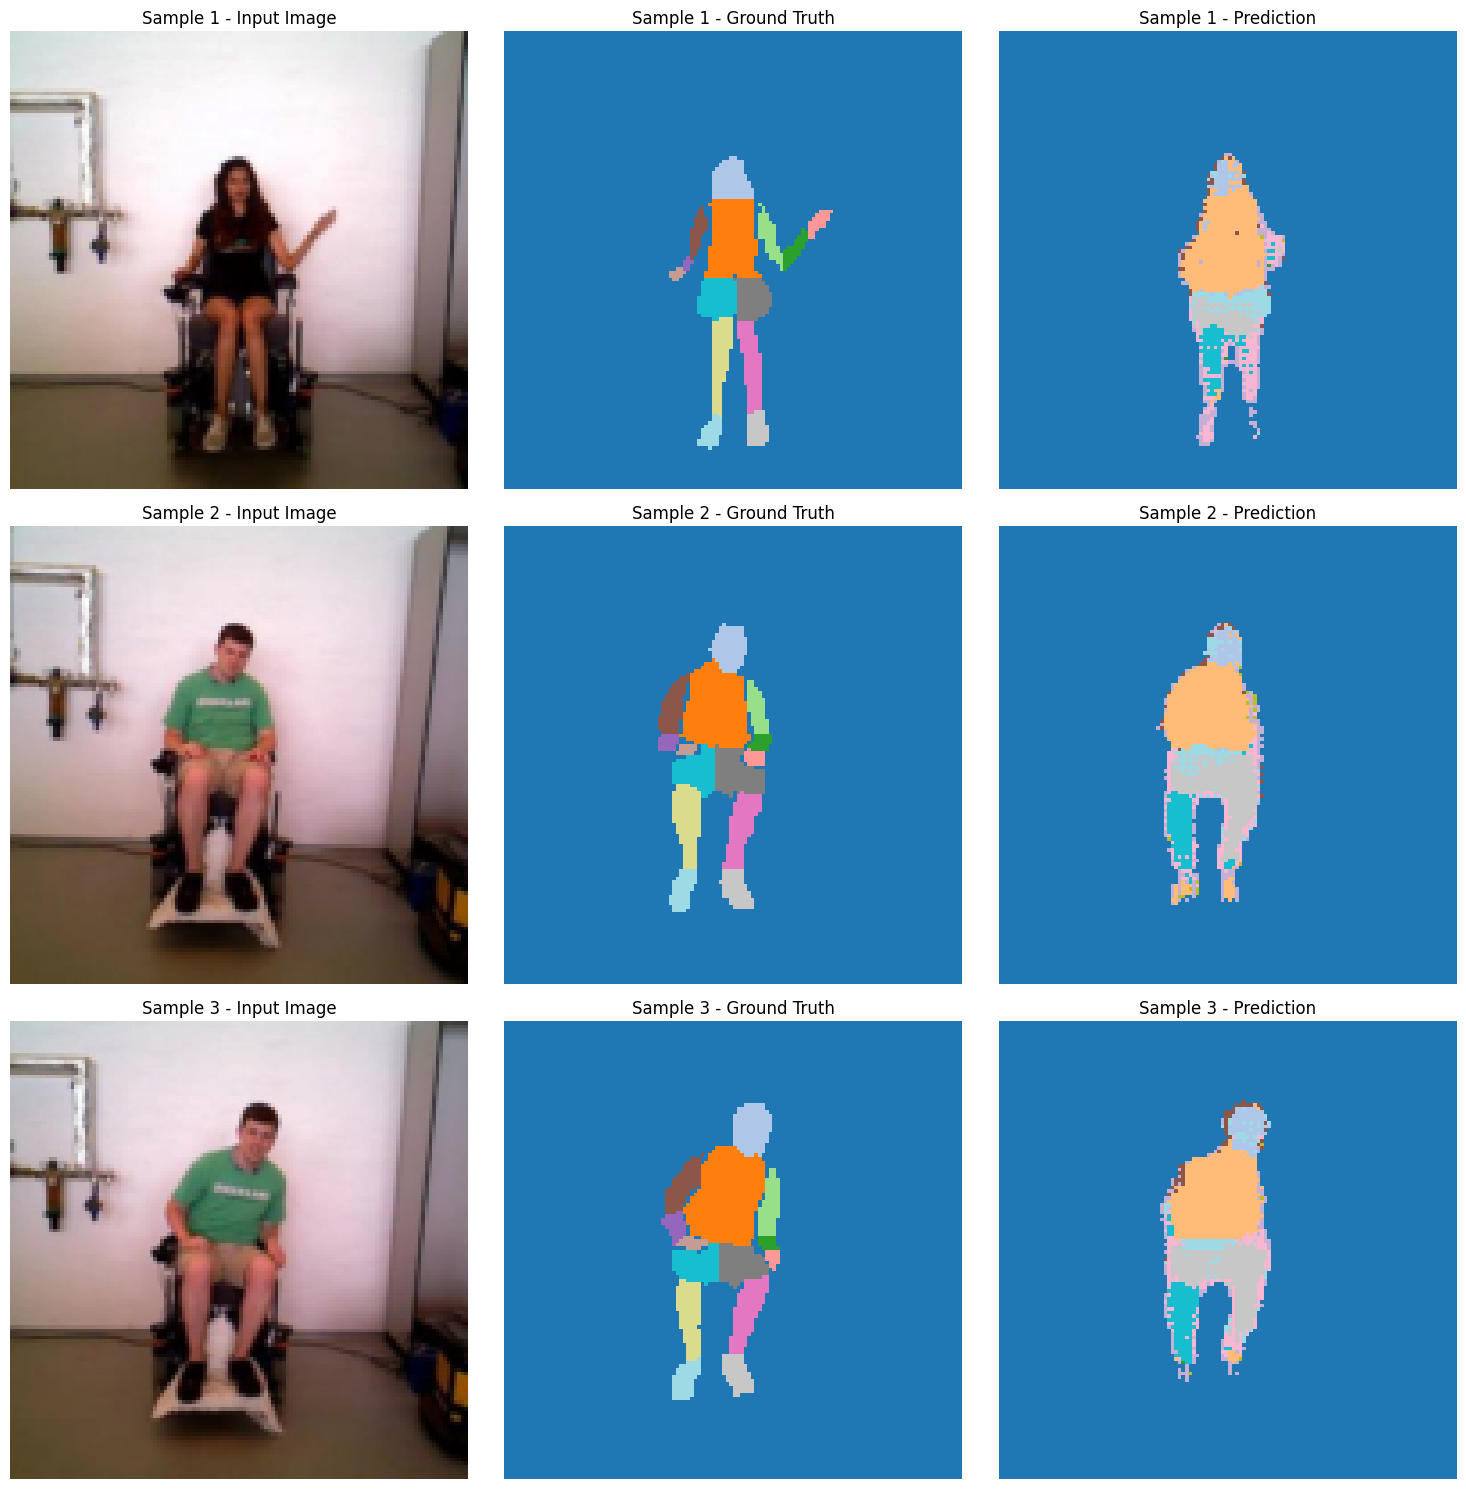

模型已保存为 'relu_model.pth'

最终结果:
训练准确率: 0.9338
验证准确率: 0.9335
训练时间: 29.90 秒


In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import scipy.io as sio  # 用于读取.mat文件

class FreiburgSittingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, train=True, train_ratio=0.8):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # 获取所有图像文件名
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        # 分割训练集和测试集
        np.random.seed(42)  # 设置随机种子确保可重复性
        indices = np.arange(len(self.img_files))
        np.random.shuffle(indices)
        
        split_idx = int(len(indices) * train_ratio)
        if train:
            self.indices = indices[:split_idx]
        else:
            self.indices = indices[split_idx:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # 获取真实索引
        true_idx = self.indices[idx]
        img_name = self.img_files[true_idx]
        
        # 加载图像
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # 构建对应的mat文件名
        # 假设mat文件与图像文件同名，只是扩展名不同
        mat_name = os.path.splitext(img_name)[0] + '.mat'
        mat_path = os.path.join(self.mask_dir, mat_name)
        
        # 加载mat文件
        try:
            mat_data = sio.loadmat(mat_path)
            
            # 提取掩码数据
            # 注意：这里需要根据实际mat文件结构调整
            # 假设mat文件中有一个名为'mask'或'segmentation'的变量
            # 您可能需要根据实际mat文件结构修改这部分
            if 'mask' in mat_data:
                mask = mat_data['mask']
            elif 'segmentation' in mat_data:
                mask = mat_data['segmentation']
            else:
                # 尝试获取第一个非特殊变量（通常.mat文件会包含一些元数据变量）
                for key in mat_data.keys():
                    if not key.startswith('__'):  # 跳过特殊变量如__header__
                        mask = mat_data[key]
                        break
            
            # 确保掩码是正确的形状和类型
            mask = np.array(mask, dtype=np.int64)
            
        except Exception as e:
            print(f"无法加载mat文件 {mat_path}: {e}")
            # 在出错的情况下提供默认掩码（全零）
            mask = np.zeros((image.height, image.width), dtype=np.int64)
        
        # 应用变换
        if self.transform:
            image = self.transform(image)
            
            # 调整掩码大小与图像一致（假设为128x128）
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize((128, 128), Image.NEAREST)
            mask = np.array(mask)
            
        # 将掩码转换为torch张量
        mask_tensor = torch.from_numpy(mask).long()
            
        return image, mask_tensor

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(2.0))  # 初值设为 1
        self.sqrt2 = torch.sqrt(torch.tensor(2.0))  # 常量提前算好（或用 register_buffer）

    def forward(self, input):
        return input / 2 * (1 + torch.erf(input / (self.sqrt2 * self.sigma)))


# 修改后的 LightweightSegNet
class LightweightSegNet(nn.Module):
    def __init__(self, num_classes=14):
        super(LightweightSegNet, self).__init__()
        
        # 单独定义每一层的 GELU 激活以跟踪不同层的 sigma
        self.gelu1 = GELU()
        self.gelu2 = GELU()
        self.gelu3 = GELU()
        self.gelu4 = GELU()
        self.gelu5 = GELU()
        self.gelu6 = GELU()

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            self.gelu1,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.gelu2,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.gelu3,
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            self.gelu4,

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            self.gelu5,

            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.BatchNorm2d(16),
            self.gelu6,

            nn.Conv2d(16, num_classes, kernel_size=1)  # 输出层
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """训练模型并评估性能"""
    model.to(device)
    
    # 记录训练过程
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    
    # 开始计时
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0
        
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            # 统计
            running_loss += loss.item()
            
            # 计算像素级准确率
            _, predicted = torch.max(outputs, 1)
            correct_pixels += (predicted == masks).sum().item()
            total_pixels += masks.numel()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_pixels / total_pixels
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)
        
        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_correct_pixels = 0
        val_total_pixels = 0
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                
                # 前向传播
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                
                # 统计
                val_running_loss += loss.item()
                
                # 计算像素级准确率
                _, predicted = torch.max(outputs, 1)
                val_correct_pixels += (predicted == masks).sum().item()
                val_total_pixels += masks.numel()
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_correct_pixels / val_total_pixels
        val_losses.append(val_epoch_loss)
        val_accuracy.append(val_epoch_acc)
        
        # 打印每个epoch的结果
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
    
    # 计算总训练时间
    total_time = time.time() - start_time
    print(f'训练完成，总用时: {total_time:.2f} 秒')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': total_time
    }

def visualize_results(results, model_name):
    """可视化训练结果"""
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(results['train_accuracy'], label='Train Accuracy')
    plt.plot(results['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    """可视化模型的预测结果"""
    model.eval()
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # 转回CPU进行可视化
            input_img = inputs[0].cpu().permute(1, 2, 0).numpy()
            # 反标准化图像
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            input_img = std * input_img + mean
            input_img = np.clip(input_img, 0, 1)
            
            true_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].cpu().numpy()
            
            # 绘制原图、真实标签和预测标签
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(input_img)
            plt.title(f'Sample {i+1} - Input Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(true_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Ground Truth')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')
            
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

def inspect_mat_file(mat_path):
    """检查.mat文件的内容和结构"""
    try:
        mat_data = sio.loadmat(mat_path)
        print(f"Mat文件内容:")
        for key in mat_data.keys():
            if not key.startswith('__'):  # 跳过特殊变量
                value = mat_data[key]
                print(f"  - {key}: 形状={value.shape}, 类型={value.dtype}, 值范围=[{np.min(value)}, {np.max(value)}]")
                # 打印唯一值，查看是否是分类标签
                unique_values = np.unique(value)
                if len(unique_values) < 20:  # 如果唯一值数量较少，可能是类别标签
                    print(f"    唯一值: {unique_values}")
        return mat_data
    except Exception as e:
        print(f"无法读取mat文件: {e}")
        return None

def main():
    # 设置路径
    img_dir = "D:/人体姿态检测2025/img"
    mask_dir = "D:/人体姿态检测2025/masks"
    
    # 检查目录是否存在
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        raise FileNotFoundError(f"请确保图像目录 {img_dir} 和掩码目录 {mask_dir} 都存在")
    
    # 首先检查一个.mat文件，了解其结构
    print("检查.mat文件结构...")
    # 查找第一个.mat文件
    mat_files = [f for f in os.listdir(mask_dir) if f.endswith('.mat')]
    if mat_files:
        sample_mat = os.path.join(mask_dir, mat_files[0])
        mat_data = inspect_mat_file(sample_mat)
    else:
        print("未找到.mat文件，请确认masks目录中包含.mat文件")
        return
    
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 数据变换
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 创建数据集
    train_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=True)
    val_dataset = FreiburgSittingDataset(img_dir, mask_dir, transform=transform, train=False)
    
    # 检查数据集大小
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")
    
    # 检查第一个样本
    sample_image, sample_mask = train_dataset[0]
    print(f"样本图像形状: {sample_image.shape}")
    print(f"样本掩码形状: {sample_mask.shape}")
    print(f"掩码唯一值: {torch.unique(sample_mask)}")
    
    # 确定类别数量 (14个部分 + 背景类)
    num_classes = len(torch.unique(sample_mask)) if len(torch.unique(sample_mask)) > 0 else 15
    print(f"检测到类别数量: {num_classes}")
    
    # 创建数据加载器
    batch_size = 16  # 小批量以减少内存使用
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # 创建模型
    model = LightweightSegNet(num_classes=num_classes)
    print(f"创建了具有{num_classes}个输出类别的模型")
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练模型
    num_epochs = 15  # 减少训练轮次以加快训练
    print(f"开始训练 GELU 模型，共 {num_epochs} 轮...")
    
    results = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=num_epochs, 
        device=device
    )
    
    # 可视化训练结果
    visualize_results(results, "ReLU_Model")
    
    # 可视化一些预测结果
    print("生成预测可视化...")
    visualize_predictions(model, val_loader, device)
    
    # 保存模型
    torch.save(model.state_dict(), 'relu_model.pth')
    print("模型已保存为 'relu_model.pth'")
    
    # 输出最终结果
    print(f"\n最终结果:")
    print(f"训练准确率: {results['train_accuracy'][-1]:.4f}")
    print(f"验证准确率: {results['val_accuracy'][-1]:.4f}")
    print(f"训练时间: {results['training_time']:.2f} 秒")

if __name__ == "__main__":
    main()